In [325]:
import numpy as np
from scipy import ndimage
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import numpy.typing as npt
from typing import List, Tuple, Any, Set, Optional
from dataclasses import dataclass
from threading import Lock
import random
from scipy.signal import convolve
import time as tm
import pickle

In [326]:
@dataclass
class GridChunk:
    start_idx: Tuple[int, int, int]
    end_idx: Tuple[int, int, int]
    S_chunk: List[npt.NDArray]
    cells_in_chunk: List[Any]


In [327]:
# Global lock and position tracking
position_lock = Lock()
occupied_positions: Set[Tuple[int, int, int]] = set()


In [328]:
def get_valid_bud_position(cell, diff, grid_shape) -> Optional[Tuple[int, int, int]]:
    """
    Find valid adjacent position for cell budding, prioritizing horizontal plane
    then looking upward if necessary.
    
    Parameters:
    cell: parent cell
    diff: grid refinement factor
    grid_shape: shape of the coarse grid
    
    Returns:
    Tuple of (x, y, z) coordinates for the new cell, or None if no valid position
    """
    current_x, current_y, current_z = int(cell.x), int(cell.y), int(cell.z)
    
    # First try positions in the same horizontal plane (z constant)
    horizontal_directions = [
        (dx, dy, 0) 
        for dx in [-1, 0, 1] 
        for dy in [-1, 0, 1] 
        if not (dx == dy == 0)
    ]
    np.random.shuffle(horizontal_directions)
    
    # Then try positions in the plane above (z + 1)
    upward_directions = [
        (dx, dy, 1) 
        for dx in [-1, 0, 1] 
        for dy in [-1, 0, 1]
    ]
    np.random.shuffle(upward_directions)
    
    # Combine the directions with horizontal first
    all_directions = horizontal_directions + upward_directions
    
    for dx, dy, dz in all_directions:
        new_x = current_x + dx
        new_y = current_y + dy
        new_z = current_z + dz
        
        # Check if position is within grid bounds
        if (0 <= new_x < grid_shape[0] * diff and
            0 <= new_y < grid_shape[1] * diff and
            0 <= new_z < grid_shape[2] * diff):
            
            # Check if position is unoccupied
            with position_lock:
                pos = (new_x, new_y, new_z)
                if pos not in occupied_positions:
                    occupied_positions.add(pos)
                    return new_x, new_y, new_z
    
    return None


In [329]:
def update_cell_population(cells, dt_cell, diff, grid_shape):
    """
    Update cell population through death and reproduction with directional budding
    
    Parameters:
    cells: list of Cell objects
    dt_cell: timestep for cell updates
    diff: grid refinement factor
    grid_shape: shape of the coarse grid
    
    Returns:
    List of new cells created during reproduction
    List of indices of cells that died
    """
    new_cells = []
    dead_cell_indices = []
    
    # Update occupied positions set with only live cells. This is wrong I think. (230125, removed the life condition)
    with position_lock:
        occupied_positions.clear()
        for cell in cells:
            #if cell.is_alive:
            occupied_positions.add((int(cell.x), int(cell.y), int(cell.z)))
    
    for idx, cell in enumerate(cells):
        if not cell.is_alive:
            continue
            
        # Process death
        if np.random.random() < cell.death_rate * dt_cell:
            cell.is_alive = False
            dead_cell_indices.append(idx)
            
            #Don't immediately do this. (removed on 230125)
            #with position_lock:
            #    occupied_positions.remove((int(cell.x), int(cell.y), int(cell.z)))
            continue
        
        # Check reproduction conditions
        can_reproduce = True
        
        if (cell.stochastic_growth and cell.reproduction_rate*dt_cell < random.random()):
            can_reproduce = False
                
        else:
            for nutrient_idx in range(cell.dependencies.shape[0]):
                if cell.dependencies[nutrient_idx, 0]:  # if cell needs this nutrient
                    if cell.S_internal[nutrient_idx] < cell.alphas[nutrient_idx]:
                        can_reproduce = False
                        break
        
        # Process reproduction through directional budding
        if can_reproduce:
            bud_position = get_valid_bud_position(cell, diff, grid_shape)
            if bud_position is not None:
                # Create daughter cell
                daughter_cell = cell.create_daughter(*bud_position)
                if daughter_cell is not None:
                    # Reset nutrients in both parent and daughter
                    cell.S_internal.fill(0)
                    daughter_cell.S_internal.fill(0)
                    new_cells.append(daughter_cell)
    
    return new_cells, dead_cell_indices

In [330]:
def convolution_laplacian_3D(M: np.ndarray) -> np.ndarray:
    #Make a big matrix to incorporate boundary conditions
    #for this implementation, we will have periodic conditions in x and y and no flux in Z.
    #This involves literally just adding rows such that the boundary conditions are satisfied.
    #For periodic, the padded layer will be the value from the opposite side of the matrix,
    #for no flux, the padded layer (-1) equals the (1) layer such that the central difference around (0) is 0
    shp = np.shape(M)
    
    #make the padded matrix
    M_padded = np.zeros((shp[0]+2,shp[1]+2,shp[2]+2))
    
    #put the original matrix inside
    M_padded[1:-1,1:-1,1:-1] = M.copy()
    
    #pad the edges, starting with Z
    M_padded[:,:,0] = M_padded[:,:,2]
    M_padded[:,:,-1] = M_padded[:,:,-3]
    
    #pad the edges, X direction
    M_padded[0,:,:] = M_padded[-2,:,:]
    M_padded[-1,:,:] = M_padded[1,:,:]
    
    #pad the edges, Y direction
    M_padded[:,0,:] = M_padded[:,-2,:]
    M_padded[:,-1,:] = M_padded[:,1,:]
    
    """
    """
    #using the 27 point stencil
    #k = 1/26*[[[2,3,2],[3,6,3],[2,3,2]],[[3,6,3],[6,-88,6],[3,6,3]],[[2,3,2],[3,6,3],[2,3,2]]]
    
    #7 point stencil
    k = [[[0,0,0],[0,1,0],[0,0,0]],[[0,1,0],[1,-6,1],[0,1,0]],[[0,0,0],[0,1,0],[0,0,0]]]
    """
    """
    
    L = convolve(M_padded, k)
    M_upd = L[2:-2,2:-2,2:-2]
    
    #L = convolve(M_padded, k, mode='same')
    #M_upd = L[1:-1,1:-1,1:-1]
    
    return M_upd


In [331]:
def michaelis_menten_uptake(S: float, vm: float, km: float) -> float:
    """
    Calculate uptake rate using Michaelis-Menten kinetics
    
    Parameters:
    S: local nutrient concentration
    vm: maximum uptake rate
    km: half-saturation constant
    
    Returns:
    Uptake rate
    """
    return vm * S / (S + km)

In [332]:
def process_cell_nutrient_interactions(cells, S_list, shape_S, diff, dt, vm_list, km_list, release_rates):
    """
    Process nutrient uptake/release for all cells using Michaelis-Menten kinetics
    
    Parameters:
    cells: list of Cell objects
    S_list: list of nutrient concentration arrays
    shape_S: shape of nutrient grids
    diff: grid refinement factor
    dt: timestep
    vm_list: list of maximum uptake rates for each nutrient
    km_list: list of half-saturation constants for each nutrient
    release_rates: list of release rates for each nutrient
    """
    n_nutrients = len(S_list)
    uptake_matrix = np.zeros((n_nutrients, *shape_S))
    release_matrix = np.zeros((n_nutrients, *shape_S))
    
    for cell in cells:
        if not cell.is_alive:
            continue
            
        i, j, k = int(cell.x // diff), int(cell.y // diff), int(cell.z // diff)
        
        if not (0 <= i < shape_S[0] and 0 <= j < shape_S[1] and 0 <= k < shape_S[2]):
            continue
            
        for nutrient_idx in range(n_nutrients):
            local_concentration = S_list[nutrient_idx][i, j, k]
            
            if cell.dependencies[nutrient_idx, 0]:  # uptake
                # Calculate uptake using Michaelis-Menten kinetics
                uptake_rate = michaelis_menten_uptake(
                    local_concentration,
                    vm_list[nutrient_idx],
                    km_list[nutrient_idx]
                )
                
                # Calculate actual uptake for this timestep
                desired_uptake = uptake_rate * dt
                actual_uptake = min(desired_uptake, local_concentration)
                
                uptake_matrix[nutrient_idx, i, j, k] += actual_uptake
                cell.process_nutrient_uptake(nutrient_idx, actual_uptake)
            
            if cell.dependencies[nutrient_idx, 1]:  # release
                release_amount = release_rates[nutrient_idx] * dt
                release_matrix[nutrient_idx, i, j, k] += release_amount
                cell.process_nutrient_release(nutrient_idx, release_amount)
    
    return uptake_matrix, release_matrix

In [333]:
def split_grid_into_chunks(S_list: List[npt.NDArray], cells: List[Any], 
                          n_chunks: int) -> List[GridChunk]:
    """
    Split the 3D grid and cells into chunks for parallel processing
    """
    shape_S = S_list[0].shape
    chunks_per_dim = int(np.cbrt(n_chunks))  # Cubic root for 3D splitting
    
    chunk_size = [s // chunks_per_dim for s in shape_S]
    chunks = []
    
    for i in range(chunks_per_dim):
        for j in range(chunks_per_dim):
            for k in range(chunks_per_dim):
                start_idx = (i * chunk_size[0], j * chunk_size[1], k * chunk_size[2])
                end_idx = ((i + 1) * chunk_size[0], (j + 1) * chunk_size[1], 
                          (k + 1) * chunk_size[2])
                
                # Get cells in this chunk
                cells_in_chunk = [
                    cell for cell in cells if cell.is_alive and
                    start_idx[0] <= cell.x < end_idx[0] and
                    start_idx[1] <= cell.y < end_idx[1] and
                    start_idx[2] <= cell.z < end_idx[2]
                ]
                
                # Get nutrient chunks
                S_chunk = [
                    S[start_idx[0]:end_idx[0],
                      start_idx[1]:end_idx[1],
                      start_idx[2]:end_idx[2]].copy()
                    for S in S_list
                ]
                
                chunks.append(GridChunk(start_idx, end_idx, S_chunk, cells_in_chunk))
    
    return chunks

In [334]:
def update_nutrient_fields(S_list, D_list, cells, diff, dt_diff, vm_list, km_list, release_rates):
    """Update nutrient concentration fields for one diffusion timestep"""
    n_nutrients = len(S_list)
    shape_S = S_list[0].shape
    S_new_list = []
    
    uptake_matrix, release_matrix = process_cell_nutrient_interactions(
        cells, S_list, shape_S, diff, dt_diff, vm_list, km_list, release_rates
    )
    
    for i in range(n_nutrients):
        laplacian = convolution_laplacian_3D(S_list[i])
        diffusion_term = D_list[i] * laplacian
        source_sink_term = release_matrix[i] - uptake_matrix[i]
        S_new = S_list[i] + dt_diff * (diffusion_term + source_sink_term)
        S_new = np.maximum(S_new, 0)
        S_new_list.append(S_new)
    
    return S_new_list

In [335]:
def process_chunk(chunk, D_list, diff, dt, vm_list, km_list, release_rates):
    """Process a single chunk of the grid"""
    S_new_chunk = update_nutrient_fields(
        chunk.S_chunk, D_list, chunk.cells_in_chunk, diff, dt,
        vm_list, km_list, release_rates
    )
    return S_new_chunk, chunk.cells_in_chunk


In [336]:
def parallel_simulate_system(S_list, D_list, cells, diff, dt_diff, dt_cell, dt_cell_to_diff_ratio,
                           vm_list, km_list, release_rates, total_time):
    """
    Parallel implementation of system simulation with spatial budding
    """
    steps_per_cell_update = int(dt_cell_to_diff_ratio)
    n_cell_updates = int(total_time / dt_cell)
    grid_shape = S_list[0].shape
    
    n_cores = mp.cpu_count()
    n_chunks = n_cores * 2
    
    # Clear global occupied positions at start
    with position_lock:
        occupied_positions.clear()
        for cell in cells:
            #if cell.is_alive:
            occupied_positions.add((int(cell.x), int(cell.y), int(cell.z)))
    
    with ProcessPoolExecutor(max_workers=n_cores) as process_executor:
        with ThreadPoolExecutor(max_workers=n_cores) as thread_executor:
            
            for cell_step in range(n_cell_updates):
                # Parallel nutrient updates
                for _ in range(steps_per_cell_update):
                    chunks = split_grid_into_chunks(S_list, cells, n_chunks)
                    
                    future_results = [
                        process_executor.submit(
                            process_chunk, chunk, D_list, diff, dt_diff,
                            vm_list, km_list, release_rates
                        )
                        for chunk in chunks
                    ]
                    
                    chunk_results = [future.result() for future in future_results]
                    
                    # Merge results
                    for chunk, (S_new_chunk, updated_cells) in zip(chunks, chunk_results):
                        for i, S in enumerate(S_list):
                            S[chunk.start_idx[0]:chunk.end_idx[0],
                              chunk.start_idx[1]:chunk.end_idx[1],
                              chunk.start_idx[2]:chunk.end_idx[2]] = S_new_chunk[i]
                        
                        for updated_cell in updated_cells:
                            for cell in cells:
                                if (cell.x == updated_cell.x and 
                                    cell.y == updated_cell.y and 
                                    cell.z == updated_cell.z):
                                    cell.internal_nutrients = updated_cell.internal_nutrients
                
                # Parallel cell population updates with spatial constraints
                cell_chunks = np.array_split(cells, n_cores)
                future_results = [
                    thread_executor.submit(
                        update_cell_population, chunk, dt_cell, diff, grid_shape
                    )
                    for chunk in cell_chunks
                ]
                
                new_cells = []
                dead_indices = []
                offset = 0
                
                for chunk_idx, future in enumerate(future_results):
                    chunk_new_cells, chunk_dead_indices = future.result()
                    new_cells.extend(chunk_new_cells)
                    dead_indices.extend([idx + offset for idx in chunk_dead_indices])
                    offset += len(cell_chunks[chunk_idx])
                
                # Update cell list
                cells = [cell for idx, cell in enumerate(cells)] 
                        #if idx not in dead_indices and cell.is_alive]
                cells.extend(new_cells)
                
                if cell_step%10==0:
                    save_data(cell_step,n_cell_updates,t_final,filepath,cells,S_list,side_len,box_height,cell_size)
                
    return S_list, cells


In [337]:
def save_data(cell_step,n_cell_updates,t_final,filepath,cells,S_list,side_len,box_height,cell_size):
    
    cell_sides = int(side_len/cell_size)
    cell_height = int(box_height/cell_size) 

    X = np.zeros((cell_sides,cell_sides,cell_height))

    for cell in final_cells:
        X[cell.x,cell.y,cell.z] = cell.typ
    
    current_time = t_final*cell_step/n_cell_updates
    
    cell_file = filepath + '%s_hours_cells.pkl'%current_time
    nutrient_file = filepath + '%s_hours_nutrients.pkl'%current_time
    
    with open(cell_file, 'wb') as f:
        pickle.dump(X, f)
    
    with open(nutrient_file, 'wb') as f:
        pickle.dump(S_list, f)

In [338]:
# Time and dimensions
side_len = 750 #microns
box_height = 300 #microns
cell_size = 5 #microns
cell_to_diff_ratio = 10
density = 10 #mm^-2

dt_diff = 1 #s
dt_cell = 0.1 #hour
dt_cell_to_diff_ratio = 360
t_final = 2 #hours

nsteps = int(t_final/dt_cell)
time = np.arange(nsteps)/dt_diff + dt_diff

D = 20 #um^2/s
DS = D/np.square(cell_size*cell_to_diff_ratio) #cell_side^2/s
#print(DS)

nx = ny = int(side_len/(cell_size*cell_to_diff_ratio))
nz = int(box_height/(cell_size*cell_to_diff_ratio))
S1 = np.zeros((nx, ny, nz))
S2 = np.zeros((nx, ny, nz))
D1, D2 = [DS,DS]

In [339]:
filepath = 'cosmo_claude_220125_'

n_strains = 2
n_nutrients = 2

#The dependencies of strain the strains on each nutrient. Within each strain and nutrient, COLUMN 1 is UPTAKE, 
#COLUMN 2 is RELEASE. 1 means they do that function, 0 means they do not
dependencies = np.zeros((n_strains,n_nutrients,2))


#This initialization is for classic CoSMO type crossfeeding.
dependencies[0,0,0] = 1 #strain 1, uptake nutrient 1
dependencies[0,1,1] = 1 #strain 1, release nutrient 2

dependencies[1,1,0] = 1 #strain 2, uptake nutrient 2
dependencies[1,0,1] = 1 #strain 2, release nutrient 1


In [340]:
"""
nutrient initialization 
"""
#We are going to do something a little wild here. Because all of our CoSMO strains have the same genetic background
#outside of the specific mutations, we are going to assume that the effect of growth of the various nutrients on
#different strains is the same. That is, we can define how a nutrient affects cell growth and apply those same 
#rates to every other cell that depends on that nutrient. In this manner, we can write out all of the rates
#for each nutrient once and then simply apply those constraints to a cell's growth by defining its dependencies. 
#This will further allow us to flexibly modulate the various interdependencies of different cell types.

#Lys
alphaL = 5.4 #nutrient required for reproduction (fmole)
rL = 0.51 #Maximum growth rate (hr^-1)
vmL = alphaL*rL #maximum uptake rate (fmole/hr)
"""
060125 The dt for diffusion is 1 second, so to ease calculations, we will put all of the parameters that are 
updated at the same time as diffusion in terms of seconds.
"""
vmL_s = vmL/(60^2) #maximum uptake rate (fmole/s)
KL = 2.1e6 #Monod constant (fmole/ml)
gammaL = 0.4 #release rate (fmole/(cell*hr))
gammaL_s = gammaL/(60^2) #release rate (fmole/(cell*s))
dL = 0.021 #death rate (hr^-1)

#Ade
alphaA = 3.1
rA = 0.44
vmA = alphaA*rA
vmA_s = vmA/(60^2)
KA = 1.3e6
gammaA = 0.26
gammaA_s = gammaA/(60^2)
dA = 0.015 #death rate (hr^-1). Should this be an order of magnitude higher?


alphas = [alphaL,alphaA]
vm_list = [vmL,vmA]
release_rates = [gammaL,gammaA]
km_list = [KL,KA]
d = [dL,dA]
r = [rL,rA]

In [341]:
class Cell:
    """Hold the properties and variables for strains."""
    def __init__(self,
                 x: int,
                 y: int,
                 z: int,
                 dependencies: np.ndarray,
                 d: float,
                 r: float,
                 n_nutrients: int,
                 alphas: list,
                 typ: int
                ):
        
        self.x = x
        self.y = y
        self.z = z
        
        self.stochastic_growth = True
        if any(dependencies[:,0]):
            self.stochastic_growth = False
        
        self.dependencies = dependencies
        self.is_alive = True
        self.death_rate = d
        self.reproduction_rate = r
        self.alphas = alphas
        self.typ = typ
        
        self.S_internal = [None]*n_nutrients
        #print(n_nutrients)
        #print(np.shape(self.S_internal))
        for ii in range(n_nutrients):
            #print(ii)
            #print(random.random()*alphas[ii]*dependencies[ii,0])
            self.S_internal[ii] = random.random()*alphas[ii]*dependencies[ii,0]
        
    
    def process_nutrient_uptake(self,n_idx,ammnt):
        self.S_internal[n_idx] += ammnt
        return None
        
    def process_nutrient_release(self,n_idx,ammnt):
        #This will be useful later when we think about pathways, but for now it is just a placeholder
        return None
    
    def create_daughter(self, x, y, z):
        """
        Create a daughter cell at the specified position
        Should return a new Cell instance with:
        - Same dependencies and parameters as parent
        - New position (x, y, z)
        - Zero internal nutrients
        """
        daughter = Cell(x,y,z,
                        self.dependencies,
                        self.death_rate,
                        n_nutrients,
                        [0,0]
                       )
        return daughter

In [342]:
def initialize_population(side_len,cell_size,n_strains,density,n_nutrients,dependencies,alphas,d):
    
    n_cells = int(density*cell_size**2*side_len**2/1e6)
    cell_sides = side_len/cell_size
    
    #seed in a box of width side_len/4
    width = int(cell_sides/4)
    offset = int(cell_sides/2 - cell_sides/8)
    
    initial_cells = [None]*n_cells
    
    for nn in range(n_cells):
        x = int(width*np.random.rand()) + offset
        y = int(width*np.random.rand()) + offset
        z = 0 #int(width*np.random.rand())
        
        #pick which strain this position will be
        strain_identifier = int(np.floor((np.random.rand()-0.5)*n_strains + 1))
            
        initial_cells[nn] = Cell(x,y,z,
                        dependencies[strain_identifier,:,:],
                        d[strain_identifier],
                        r[strain_identifier],
                        n_nutrients,
                        alphas,
                        int(strain_identifier+1)
                       )
        
    return initial_cells

In [343]:
initial_cells = initialize_population(side_len,cell_size,n_strains,density,n_nutrients,dependencies,alphas,d)

begin_time = tm.time()

# Run parallel simulation
S_list_final, final_cells = parallel_simulate_system(
    [S1, S2], [D1, D2], initial_cells, cell_to_diff_ratio,
    dt_diff, dt_cell, dt_cell_to_diff_ratio, vm_list, km_list, release_rates,
    t_final
)

end_time = tm.time()
    
print('one 2 hour simulation took %s'%(end_time-begin_time))

print('Done! :D')

one 2 hour simulation took 1138.1700148582458
Done! :D


In [344]:
#let's plot some stuff!!
from matplotlib import pyplot as plt

In [345]:
cell_sides = int(side_len/cell_size)
cell_height = int(box_height/cell_size) 

X = np.zeros((cell_sides,cell_sides,cell_height))

for cell in final_cells:
    X[cell.x,cell.y,cell.z] = cell.typ

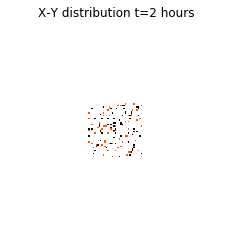

In [346]:

plt.imshow(X[:,:,0],cmap = 'hot_r')
plt.gca().axis('off')
plt.title('X-Y distribution t=%s hours'%t_final,c='k')
#plt.figure(figsize=(20,20))
plt.show()

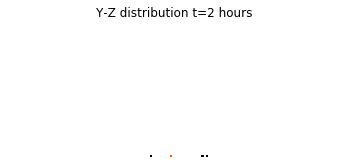

In [347]:
sz = np.shape(X)
#tr = transforms.Affine2D().rotate_deg(90)

plt.imshow(X[int(sz[0]/2),:,:].transpose(),cmap = 'hot_r')
plt.gca().axis('off')
plt.title('Y-Z distribution t=%s hours'%t_final,c='k')
plt.gca().invert_yaxis()
#plt.figure(figsize=(20,20))
plt.show()